<a href="https://colab.research.google.com/github/rituparrna33/Python-Connection-to-MySQL/blob/main/DoorDash_Delivery_Duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://platform.stratascratch.com

Assignment
When a consumer places an order on DoorDash, they show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, I will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

Start: the time consumer submits the order (created_at) to
End: when the order will be delivered to the consumer (actual_delivery_time)

Data Description from Stratascratch
The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

Columns in historical_data.csv

**Time features**

market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

**Store features**

store_id: an id representing the restaurant the order was submitted for
store_primary_category: cuisine category of the restaurant, e.g., italian, asian
order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Order features**

total_items: total number of items in the order
subtotal: total value of the order submitted (in cents)
num_distinct_items: number of distinct items included in the order
min_item_price: price of the item with the least cost in the order (in cents)
max_item_price: price of the item with the highest cost in the order (in cents)

**Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

**Predictions from other models**

We have predictions from other models for various stages of delivery process that we can use:

estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

Tasks:

*  Build a model to predict the total delivery duration seconds (as defined above)
*   Feel free to generate additional features from the given data to improve model performance. Explain:model(s) used,how you evaluated your model performance on the historical data,any data processing you performed on the data,feature engineering choices you made,other information you would like to share your modeling approach.

Steps 
look at the csv file
figure out which ones need to be encoded which ones dropped, which ones renamed

do we need market id, store id
extract actual delivery time
separate by hour
encode store category?
shorten last 3 colum names
validate
column of difference between created at and delivery

In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime

In [4]:
# read dataset
data = pd.read_csv("historical_data.csv")
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845.0,american,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477.0,mexican,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477.0,NaN,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477.0,NaN,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477.0,NaN,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0


In [5]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137404 entries, 0 to 137403
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     136703 non-null  float64
 1   created_at                                    137404 non-null  object 
 2   actual_delivery_time                          137399 non-null  object 
 3   store_id                                      137403 non-null  float64
 4   store_primary_category                        134103 non-null  object 
 5   order_protocol                                136708 non-null  float64
 6   total_items                                   137403 non-null  float64
 7   subtotal                                      137403 non-null  float64
 8   num_distinct_items                            137403 non-null  float64
 9   min_item_price                                13

In [6]:
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,136703.000000,137403.000000,136708.000000,137403.000000,137403.000000,137403.000000,137403.000000,137403.000000,126035.000000,126035.000000,126035.000000,137403.000000,137041.000000
mean,2.960564,3560.974353,2.831166,3.223176,2704.246487,2.688704,687.098775,1167.462443,45.288229,42.176388,58.771849,309.575650,544.828438
std,1.514914,2047.604478,1.476767,2.749982,1836.663918,1.639338,527.436663,569.093657,34.767142,32.320397,53.060734,90.366791,219.564232
min,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-3.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1752.000000,1.000000,2.000000,1420.000000,2.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3614.000000,3.000000,3.000000,2231.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,42.000000,251.000000,543.000000
75%,4.000000,5290.000000,4.000000,4.000000,3420.000000,3.000000,949.000000,1399.000000,66.000000,63.000000,86.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,8999.000000,8999.000000,171.000000,154.000000,285.000000,1740.000000,2088.000000


In [7]:
# change object to datetime

data['created_at']= pd.to_datetime(data['created_at'])
data['actual_delivery_time']= pd.to_datetime(data['actual_delivery_time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137404 entries, 0 to 137403
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     136703 non-null  float64       
 1   created_at                                    137404 non-null  datetime64[ns]
 2   actual_delivery_time                          137399 non-null  datetime64[ns]
 3   store_id                                      137403 non-null  float64       
 4   store_primary_category                        134103 non-null  object        
 5   order_protocol                                136708 non-null  float64       
 6   total_items                                   137403 non-null  float64       
 7   subtotal                                      137403 non-null  float64       
 8   num_distinct_items                            137403 n

In [8]:
#feature creation, the value of interest time to deliver is the difference between 
from datetime import timedelta
data['total_delivery_time']=(data['actual_delivery_time']-data['created_at']).dt.seconds

In [9]:
#busy dashers ratio
data['busy_dasher_ratio']=data['total_busy_dashers']/data['total_onshift_dashers']

In [10]:
data['nonprep_duration']=data['estimated_order_place_duration']+data['estimated_store_to_consumer_driving_duration']

In [11]:
#clean/preprocess/manipulate
# then divide ino test and train dataset, 80/20
#the test dataset should not see any operations on it
#check for collinearity


In [12]:
#One hot encoding

data['market_id'].nunique()

6

In [13]:
data['store_id'].nunique()

4766

In [14]:
data['order_protocol'].nunique()

7

In [15]:
#create dummies for order protocol
order_protocol_dummies=pd.get_dummies(data['order_protocol'])
order_protocol_dummies=order_protocol_dummies.add_prefix('order_protocol_')

In [16]:
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [17]:
market_id_dummies=pd.get_dummies(data['market_id'])
market_id_dummies=order_protocol_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_order_protocol_1.0,market_id_order_protocol_2.0,market_id_order_protocol_3.0,market_id_order_protocol_4.0,market_id_order_protocol_5.0,market_id_order_protocol_6.0,market_id_order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [18]:
data['store_primary_category'].value_counts()

american      13958
pizza         11807
mexican       11347
burger         8537
sandwich       6594
              ...  
moroccan          3
belgian           2
indonesian        2
african           1
chocolate         1
Name: store_primary_category, Length: 73, dtype: int64

In [19]:
#find the mode category for each store id
store_id_unique= data['store_id'].unique().tolist()
store_id_and_category={store_id: data[data.store_id==store_id].store_primary_category.mode() for store_id in store_id_unique}


In [20]:
def fill(store_id):
  try:
    return store_id_and_category[store_id].values[0]
  except:
    return np.nan
#fill null values

data['nan_free_store_primary_category']= data.store_id.apply(fill)

In [21]:
store_primary_category_dummies=pd.get_dummies(data.nan_free_store_primary_category)
store_primary_category_dummies=store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_alcohol,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
train_data= data.drop(columns=['created_at','market_id','store_primary_category','actual_delivery_time',
                               'nan_free_store_primary_category'])
train_data.head()


,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_dasher_ratio,nonprep_duration
0,1845.0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,0.424242,1307.0
1,5477.0,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,2.000000,1136.0
2,5477.0,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,1781.0,0.000000,1136.0
3,5477.0,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,3075.0,1.000000,735.0
4,5477.0,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,2390.0,1.000000,1096.0


In [23]:
train_data=pd.concat([train_data,order_protocol_dummies,market_id_dummies,store_primary_category_dummies], axis=1)

In [24]:
train_data.shape

(137404, 101)

In [25]:
#align dattype
train_data= train_data.astype("float32")
train_data.head()

,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,1845.0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5477.0,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5477.0,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5477.0,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5477.0,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137404 entries, 0 to 137403
Columns: 101 entries, store_id to category_vietnamese
dtypes: float32(101)
memory usage: 52.9 MB


In [27]:
train_data['busy_dasher_ratio'].describe()

count    1.236380e+05
mean              NaN
std               NaN
min              -inf
25%      8.275862e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dasher_ratio, dtype: float64

In [28]:
np.where(np.any(~np.isfinite(train_data), axis=0)==True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)

In [29]:
train_data.replace([np.inf,-np.inf],np.nan, inplace=True)
train_data.dropna(inplace=True)

In [30]:
train_data.shape

(122648, 101)

In [31]:
#correlation matrix
corr=train_data.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))

<Axes: >

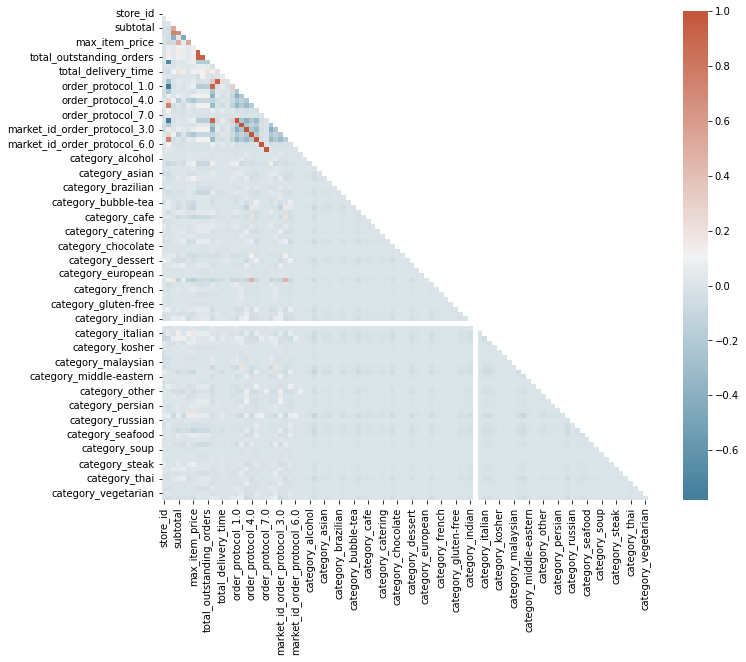

In [32]:
#masked correlation matrix
f,ax=plt.subplots(figsize=(11,9))
cmap=sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap)

In [33]:
train_data['category_indonesian'].describe()

count    122648.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [34]:
# 2 functions to test the correlations

def get_reduntant_pairs(df):
  pairs_to_drop=set()
  cols=df.columns
  for i in range(0,df.shape[1]):
    for j in range(0,i+1):
      pairs_to_drop.add((cols[i],cols[j]))
  return pairs_to_drop

In [35]:
def get_top_abs_correlations(df,n=5):
  au_corr=df.corr().abs().unstack()
  labels_to_drop= get_reduntant_pairs(df)
  au_corr=au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
  return au_corr[0:n]


In [36]:
print('Top absolute corelations')
print(get_top_abs_correlations(train_data,20))

Top absolute corelations
order_protocol_3.0                            market_id_order_protocol_3.0      1.000000
order_protocol_5.0                            market_id_order_protocol_5.0      1.000000
order_protocol_1.0                            market_id_order_protocol_1.0      1.000000
order_protocol_2.0                            market_id_order_protocol_2.0      1.000000
order_protocol_7.0                            market_id_order_protocol_7.0      1.000000
order_protocol_6.0                            market_id_order_protocol_6.0      1.000000
order_protocol_4.0                            market_id_order_protocol_4.0      1.000000
total_onshift_dashers                         total_busy_dashers                0.941988
                                              total_outstanding_orders          0.934472
total_busy_dashers                            total_outstanding_orders          0.932013
estimated_store_to_consumer_driving_duration  nonprep_duration                  0.922

In [37]:
train_data= data.drop(columns=['created_at','market_id','store_id','store_primary_category','actual_delivery_time',
                               'nan_free_store_primary_category','order_protocol'])
train_data.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_dasher_ratio,nonprep_duration
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,3779.0,0.424242,1307.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,4024.0,2.000000,1136.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,1781.0,0.000000,1136.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,3075.0,1.000000,735.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,2390.0,1.000000,1096.0


In [38]:

train_data=pd.concat([train_data,order_protocol_dummies,store_primary_category_dummies], axis=1)

train_data=train_data.drop(columns=['total_onshift_dashers','total_busy_dashers','category_indonesian','nonprep_duration'])
train_data= train_data.astype("float32")
train_data.replace([np.inf,-np.inf],np.nan, inplace=True)
train_data.dropna(inplace=True)
train_data.shape

(123280, 88)

In [39]:
def get_top_abs_correlations(df,n=5):
  au_corr=df.corr().abs().unstack()
  labels_to_drop= get_reduntant_pairs(df)
  au_corr=au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
  return au_corr[0:n]
print('Top absolute corelations')
print(get_top_abs_correlations(train_data,20))

Top absolute corelations
estimated_order_place_duration                order_protocol_1.0     0.901178
total_items                                   num_distinct_items     0.735593
subtotal                                      num_distinct_items     0.674275
min_item_price                                max_item_price         0.542168
total_items                                   subtotal               0.529912
subtotal                                      max_item_price         0.515172
order_protocol_4.0                            category_fast          0.481616
num_distinct_items                            min_item_price         0.448378
order_protocol_1.0                            order_protocol_3.0     0.392220
estimated_order_place_duration                order_protocol_3.0     0.384324
total_items                                   min_item_price         0.380947
order_protocol_1.0                            order_protocol_5.0     0.321959
order_protocol_3.0                     

In [40]:
train_data= data.drop(columns=['created_at','market_id','store_id','store_primary_category','actual_delivery_time',
                               'nan_free_store_primary_category','order_protocol'])
train_data=pd.concat([train_data,store_primary_category_dummies], axis=1)

train_data=train_data.drop(columns=['total_onshift_dashers','total_busy_dashers','category_indonesian','nonprep_duration'])
train_data= train_data.astype("float32")
train_data.replace([np.inf,-np.inf],np.nan, inplace=True)
train_data.dropna(inplace=True)
train_data.shape

(123280, 81)

In [41]:
print('Top absolute corelations')
print(get_top_abs_correlations(train_data,20))

Top absolute corelations
total_items                                   num_distinct_items                0.735593
subtotal                                      num_distinct_items                0.674275
min_item_price                                max_item_price                    0.542168
total_items                                   subtotal                          0.529912
subtotal                                      max_item_price                    0.515172
num_distinct_items                            min_item_price                    0.448378
total_items                                   min_item_price                    0.380947
estimated_store_to_consumer_driving_duration  total_delivery_time               0.222454
subtotal                                      total_delivery_time               0.205332
total_outstanding_orders                      total_delivery_time               0.193862
max_item_price                                category_italian                  0.184

In [42]:
#Feauture engineering
#new features
train_data['percent_distinct']=train_data['num_distinct_items']/train_data['total_items']
train_data['avg_price']=train_data['subtotal']/train_data['total_items']
train_data.drop(columns=['num_distinct_items','subtotal'],inplace=True)
print('Top absolute corelations')
print(get_top_abs_correlations(train_data,20))

Top absolute corelations
min_item_price                                avg_price                         0.861625
max_item_price                                avg_price                         0.773340
min_item_price                                max_item_price                    0.542168
total_items                                   percent_distinct                  0.437965
                                              min_item_price                    0.380947
                                              avg_price                         0.307323
percent_distinct                              avg_price                         0.229817
category_pizza                                avg_price                         0.229021
estimated_store_to_consumer_driving_duration  total_delivery_time               0.222454
total_outstanding_orders                      total_delivery_time               0.193862
max_item_price                                category_italian                  0.184

In [43]:
train_data['price_range']=train_data['max_item_price']-train_data['min_item_price']
train_data.drop(columns=['max_item_price','min_item_price'],inplace=True)
print('Top absolute corelations')
print(get_top_abs_correlations(train_data,20))

Top absolute corelations
total_items                                   percent_distinct                  0.437965
                                              price_range                       0.315469
                                              avg_price                         0.307323
percent_distinct                              avg_price                         0.229817
category_pizza                                avg_price                         0.229021
estimated_store_to_consumer_driving_duration  total_delivery_time               0.222454
total_outstanding_orders                      total_delivery_time               0.193862
category_fast                                 avg_price                         0.183006
total_items                                   category_fast                     0.177079
category_italian                              avg_price                         0.174377
total_outstanding_orders                      estimated_order_place_duration    0.171

In [44]:
train_data.shape

(123280, 80)

In [45]:
train_data.columns

Index(['total_items', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'total_delivery_time',
       'busy_dasher_ratio', 'category_afghan', 'category_alcohol',
       'category_american', 'category_argentine', 'category_asian',
       'category_barbecue', 'category_belgian', 'category_brazilian',
       'category_breakfast', 'category_british', 'category_bubble-tea',
       'category_burger', 'category_burmese', 'category_cafe',
       'category_cajun', 'category_caribbean', 'category_catering',
       'category_cheese', 'category_chinese', 'category_chocolate',
       'category_comfort-food', 'category_convenience-store',
       'category_dessert', 'category_dim-sum', 'category_ethiopian',
       'category_european', 'category_fast', 'category_filipino',
       'category_french', 'category_gastropub', 'category_german',
       'category_gluten-free', 'category_greek', 'category_hawaiian',
       'category_indi

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
def compute_vif(features):
  vif_data=pd.DataFrame()
  vif_data['feature']=features
  vif_data['VIF']=[variance_inflation_factor(train_data[features].values,i) for i in range(len(features))]
  return vif_data.sort_values(by=['VIF']).reset_index(drop=True)





In [55]:
#apply VIF computation
features=train_data.drop(columns=['total_delivery_time']).columns.to_list()
print(features)
vif_data=compute_vif(features)
vif_data

['total_items', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'busy_dasher_ratio', 'category_afghan', 'category_alcohol', 'category_american', 'category_argentine', 'category_asian', 'category_barbecue', 'category_belgian', 'category_brazilian', 'category_breakfast', 'category_british', 'category_bubble-tea', 'category_burger', 'category_burmese', 'category_cafe', 'category_cajun', 'category_caribbean', 'category_catering', 'category_cheese', 'category_chinese', 'category_chocolate', 'category_comfort-food', 'category_convenience-store', 'category_dessert', 'category_dim-sum', 'category_ethiopian', 'category_european', 'category_fast', 'category_filipino', 'category_french', 'category_gastropub', 'category_german', 'category_gluten-free', 'category_greek', 'category_hawaiian', 'category_indian', 'category_irish', 'category_italian', 'category_japanese', 'category_korean', 'category_kosher', 'category_latin-american', 'cate

,feature,VIF
0,category_chocolate,1.000684
1,category_belgian,1.001036
2,category_moroccan,1.001979
3,category_spanish,1.003682
4,category_russian,1.004418
...,...,...
74,busy_dasher_ratio,6.517000
75,category_american,6.884463
76,estimated_store_to_consumer_driving_duration,7.179993
77,estimated_order_place_duration,13.444577


In [56]:
#DROP FEATURES WITH ABOVE 20 vif
multicollinearity=True
while multicollinearity:
  highest_vif_feature=vif_data['feature'].values.tolist()[-1]
  print("I will remove ",highest_vif_feature)
  features.remove(highest_vif_feature)
  vif_data=compute_vif(features)
  multicollinearity=False if len(vif_data[vif_data.VIF>20])==0 else True

selected_features=vif_data['feature'].values.tolist()
vif_data

I will remove  percent_distinct


,feature,VIF
0,category_chocolate,1.000518
1,category_belgian,1.000643
2,category_moroccan,1.001529
3,category_spanish,1.002562
4,category_russian,1.002836
...,...,...
73,category_american,4.507347
74,avg_price,5.897657
75,busy_dasher_ratio,6.500400
76,estimated_store_to_consumer_driving_duration,7.157897


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X=train_data[selected_features]
y=train_data['total_delivery_time']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=42)